# Imports

In [1]:
# Checa ambiente - se rodando local não usa o Google Drive
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if (IN_COLAB):
    !pip install pytorch_lightning -qqq
    import pytorch_lightning
    !pip install neptune
    import neptune
    from google.colab import drive 
    drive.mount('/content/gdrive')

In [3]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [4]:
# Redução das mensagens de log no terminal.
import logging
log = logging.getLogger("pytorch_lightning")
log.propagate = False
log.setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

# Carregamento dos dados

In [5]:
if (IN_COLAB):
    root = '/content/gdrive/MyDrive/IA901A_Projeto/data/interim/OASIS_slices2_flat'
else:
    root = 'OASIS_slices2_flat/'

transform_base = transforms.Compose([
    transforms.ToTensor()
    ])
transform_rotate = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor()
    ])
transform_hzflip = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])
transform_resize = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
    ])
transform_crop = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor()
    ])
transform_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])

In [6]:
dataset0=datasets.ImageFolder(root=root,transform=None)
print(len(dataset0))
class_names=dataset0.classes
print(class_names)
print(len(class_names))

4344
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
4


In [7]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform, batch_size=32):
        super().__init__()
        self.root_dir = root
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_test = n_data - n_train

        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(42))

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset

In [8]:
# Datamodules baseados nas transformações

datamodule_base = DataModule(transform_base)
datamodule_base.setup()

datamodule_rotate = DataModule(transform_rotate)
datamodule_rotate.setup()

datamodule_hzflip = DataModule(transform_hzflip)
datamodule_hzflip.setup()

datamodule_resize = DataModule(transform_resize)
datamodule_resize.setup()

datamodule_crop = DataModule(transform_crop)
datamodule_crop.setup()

datamodule_normalize = DataModule(transform_normalize)
datamodule_normalize.setup()

# Vizualizando imagens

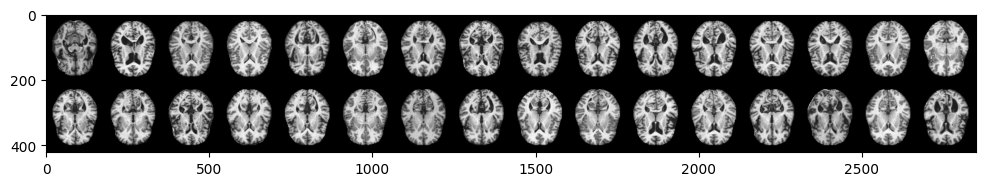

In [9]:
for images, labels in datamodule_base.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

# Definindo e treinando o modelo base: AlexNet

In [10]:
print(len(class_names))

4


In [11]:
import torchmetrics
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

batch_size = 32

class MyModel(LightningModule):

    def __init__(self):
        num_classes = len(class_names)
        super().__init__()
        self.model = models.alexnet(pretrained=True)
        self.model.classifier = nn.Sequential( nn.Linear(9216,1024),
                                               nn.ReLU(),
                                               nn.Dropout(p=0.5),
                                               nn.Linear(1024, num_classes),
                                               nn.LogSoftmax(dim=1))
        # TorchMetrics
        metrics = MetricCollection([
            MulticlassAccuracy(num_classes),
            MulticlassPrecision(num_classes),
            MulticlassRecall(num_classes)
        ])
        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')
        self.test_metrics = metrics.clone(prefix='test_')

        #self.all_labels = torch.empty((batch_size), device=torch.device('cuda'))
        #self.all_preds = torch.empty((batch_size), device=torch.device('cuda'))

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)

        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        output = self.train_metrics(pred, y)
        self.log_dict(output)
        
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)

        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        output = self.val_metrics(pred, y)
        self.log_dict(output)
        

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        
        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))
        
        if (batch_idx == 0):
            self.all_labels = y.clone()
            self.all_preds = pred.clone()
        else:
            self.all_labels = torch.cat((self.all_labels, y))
            self.all_preds = torch.cat((self.all_preds, pred))
        
        output = self.test_metrics(pred, y)
        self.log_dict(output)


# Treinamento dos modelos

In [23]:
epochs = 50
model_base = MyModel()
trainer_base = pl.Trainer(max_epochs=epochs)
trainer_base.fit(model_base, datamodule_base)

model_rotate = MyModel()
trainer_rotate = pl.Trainer(max_epochs=epochs)
trainer_rotate.fit(model_rotate, datamodule_rotate)

model_hzflip = MyModel()
trainer_hzflip = pl.Trainer(max_epochs=epochs)
trainer_hzflip.fit(model_hzflip, datamodule_hzflip)

model_resize = MyModel()
trainer_resize = pl.Trainer(max_epochs=epochs)
trainer_resize.fit(model_resize, datamodule_resize)

model_crop = MyModel()
trainer_crop = pl.Trainer(max_epochs=epochs)
trainer_crop.fit(model_crop, datamodule_crop)

model_normalize = MyModel()
trainer_normalize = pl.Trainer(max_epochs=epochs)
trainer_normalize.fit(model_normalize, datamodule_normalize)

Epoch 49: 100%|██████████| 109/109 [00:17<00:00,  6.26it/s, v_num=66]


# Teste dos modelos

In [24]:
print("Base Model")
datamodule_base.setup(stage='test')
test_loader_base = datamodule_base.test_dataloader()
metrics_base = trainer_base.test(dataloaders=test_loader_base)

print("Base Model + Rotation")
datamodule_rotate.setup(stage='test')
test_loader_rotate = datamodule_rotate.test_dataloader()
metrics_rotate = trainer_rotate.test(dataloaders=test_loader_rotate)

print("Base Model + Horizontal Flip")
datamodule_hzflip.setup(stage='test')
test_loader_hzflip = datamodule_hzflip.test_dataloader()
metrics_hzflip = trainer_hzflip.test(dataloaders=test_loader_hzflip)

print("Base Model + Resize")
datamodule_resize.setup(stage='test')
test_loader_resize = datamodule_resize.test_dataloader()
metrics_resize = trainer_resize.test(dataloaders=test_loader_resize)

print("Base Model + Crop")
datamodule_crop.setup(stage='test')
test_loader_crop = datamodule_crop.test_dataloader()
metrics_crop = trainer_crop.test(dataloaders=test_loader_crop)

print("Base Model + Normalize")
datamodule_normalize.setup(stage='test')
test_loader_normalize = datamodule_normalize.test_dataloader()
metrics_normalize = trainer_normalize.test(dataloaders=test_loader_normalize)

Base Model
Testing DataLoader 0: 100%|██████████| 28/28 [00:03<00:00,  7.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.7791880965232849     │
│ test_MulticlassPrecision  │     0.751227855682373     │
│   test_MulticlassRecall   │    0.7791880965232849     │
└───────────────────────────┴───────────────────────────┘

Base Model + Rotation
Testing DataLoader 0: 100%|██████████| 28/28 [00:03<00:00,  7.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.7834276556968689     │
│ test_MulticlassPrecision  │    0.7616645693778992     │
│   test_MulticlassRecall   │    0.7834276556968689     │
└───────────────────────────┴───────────────────────────┘

Base Model + Horizontal Flip
Testing DataLoader 0: 100%|██████████| 28/28 [00:03<00:00,  7.58it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │           0.25            │
│ test_MulticlassPrecision  │    0.14758342504501343    │
│   test_MulticlassRecall   │           0.25            │
└───────────────────────────┴───────────────────────────┘

Base Model + Resize
Testing DataLoader 0: 100%|██████████| 28/28 [00:05<00:00,  5.06it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.8279557824134827     │
│ test_MulticlassPrecision  │     0.820755124092102     │
│   test_MulticlassRecall   │    0.8279557824134827     │
└───────────────────────────┴───────────────────────────┘

Base Model + Crop
Testing DataLoader 0: 100%|██████████| 28/28 [00:03<00:00,  7.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.8069373965263367     │
│ test_MulticlassPrecision  │    0.8059629797935486     │
│   test_MulticlassRecall   │    0.8069373965263367     │
└───────────────────────────┴───────────────────────────┘

Base Model + Normalize
Testing DataLoader 0: 100%|██████████| 28/28 [00:03<00:00,  7.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.7989600300788879     │
│ test_MulticlassPrecision  │    0.7842286825180054     │
│   test_MulticlassRecall   │    0.7989600300788879     │
└───────────────────────────┴───────────────────────────┘

In [14]:
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


# Matrizes de Confusão

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

def plot_matrix(title, model):

    ax = plt.subplot()
    cm = confusion_matrix(model.all_labels.cpu(), model.all_preds.cpu())

    sns.set_style("darkgrid")
    sns.set(rc={"figure.figsize":(20, 4)})
    colormap = sns.color_palette("Blues",12)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=colormap)  

    # labels, title and ticks
    ax.set_xlabel('Predições:')
    ax.set_ylabel('Labels:')
    ax.set_title("Matriz de confusão - " + title); 
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names, rotation=0)

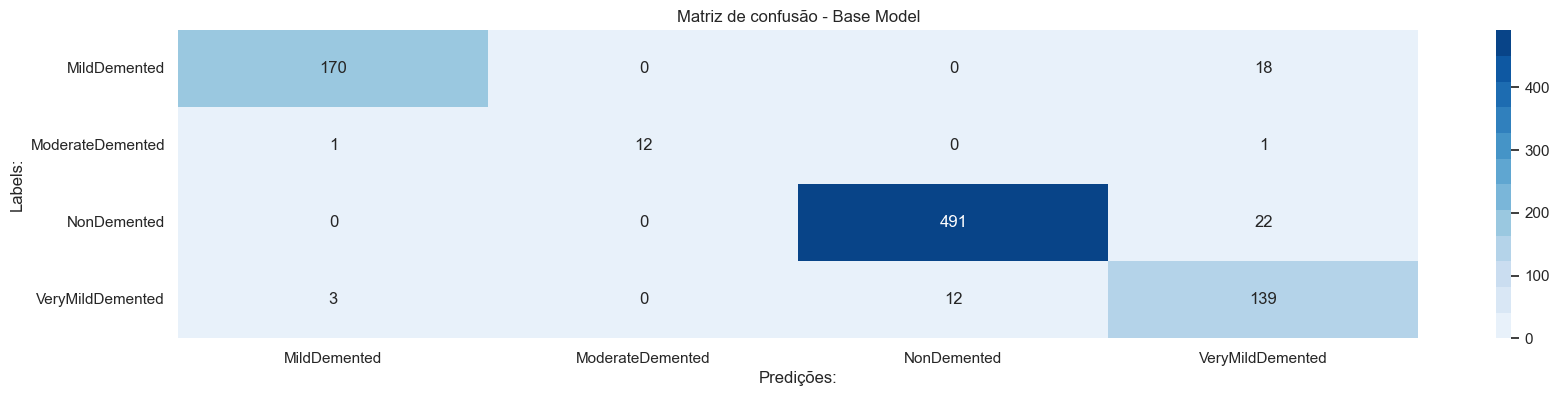

In [22]:
plot_matrix("Base Model", model_base)

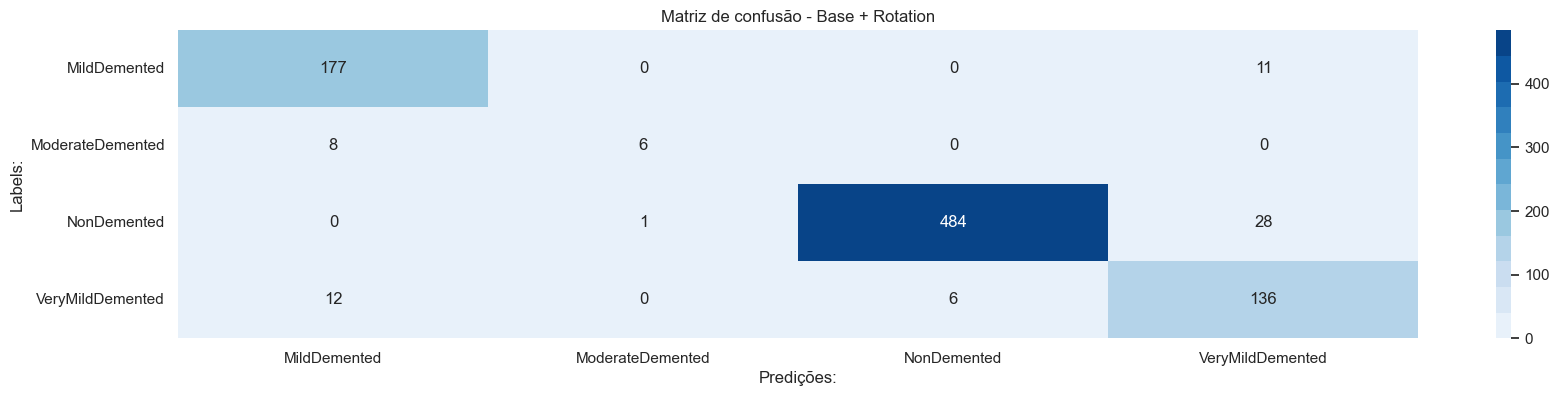

In [17]:
plot_matrix("Base + Rotation", model_rotate)

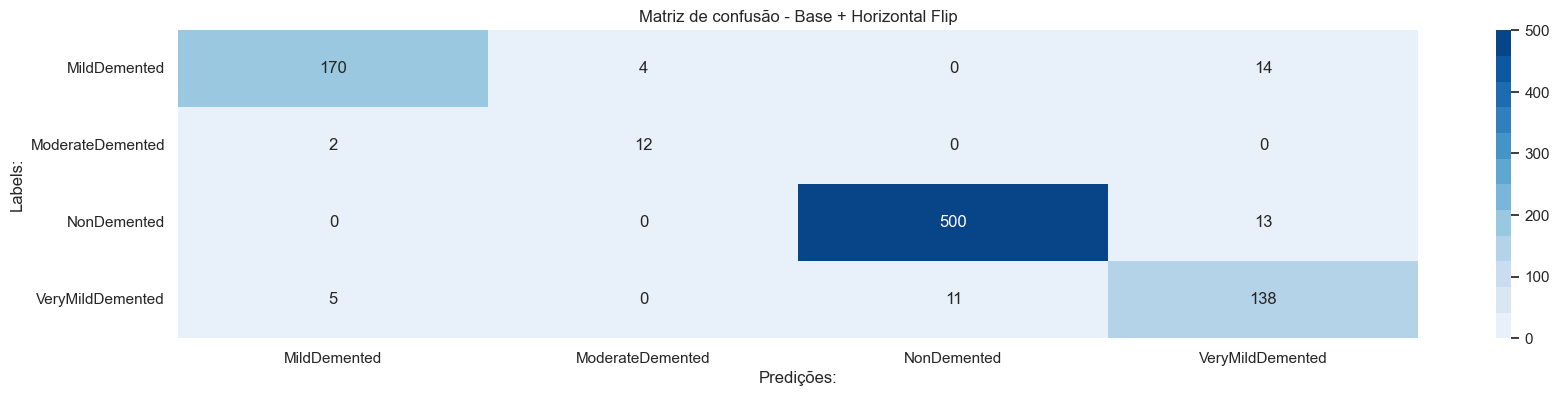

In [18]:
plot_matrix("Base + Horizontal Flip", model_hzflip)

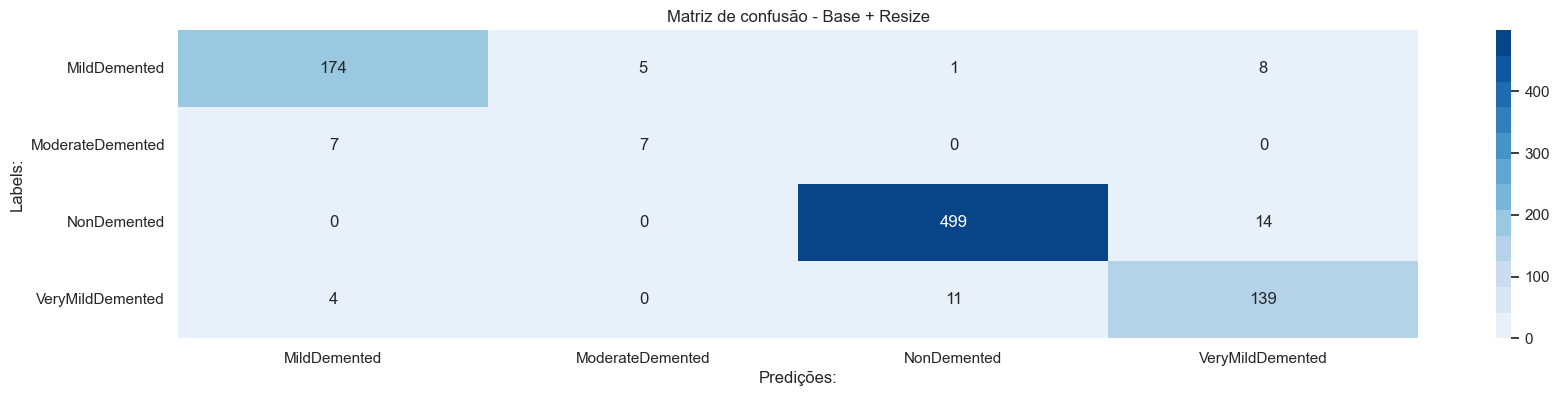

In [19]:
plot_matrix("Base + Resize", model_resize)

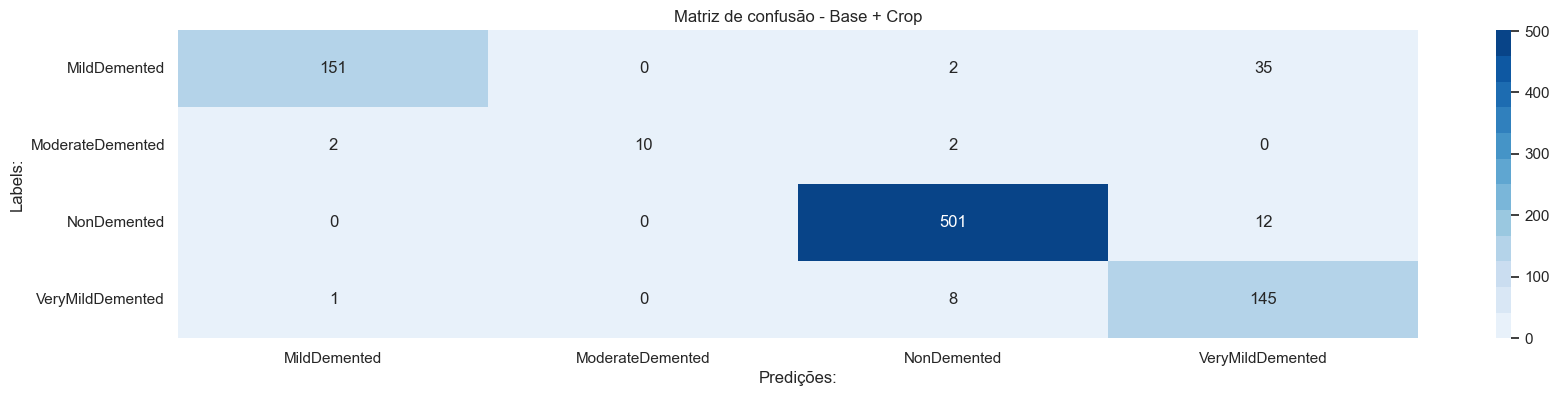

In [20]:
plot_matrix("Base + Crop", model_crop)

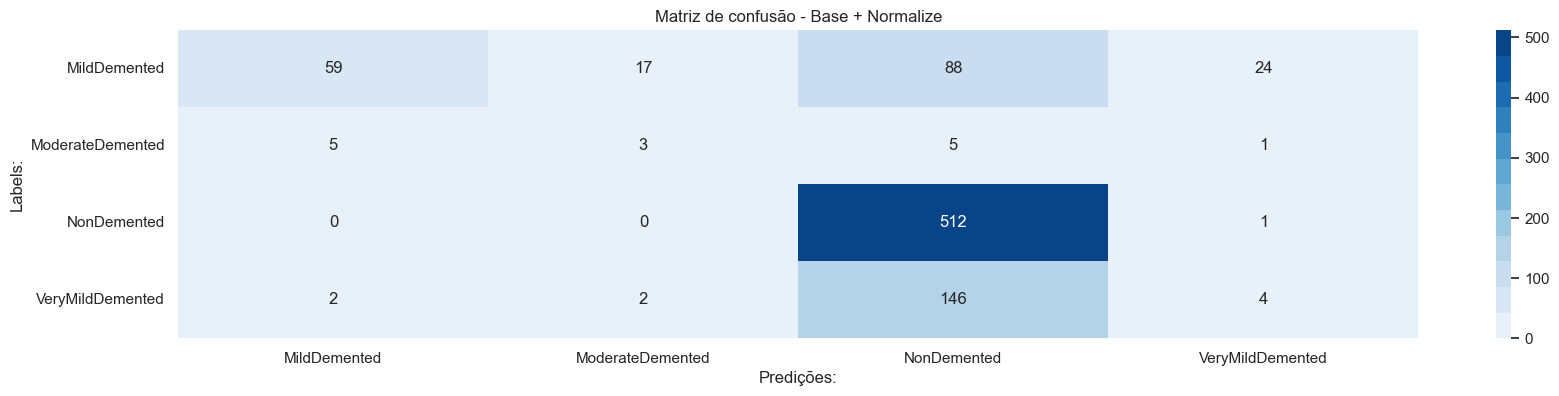

In [21]:
plot_matrix("Base + Normalize", model_normalize)